In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from models import GFNN
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

In [2]:
# import data from pickle file
data = pd.read_pickle("SimulatedWaves.pkl")
wave = np.array(data['Wave'])
wave = [np.array(x) for x in wave]
NumPh = np.array([int(len(x)-1) for x in data['Times']])

In [3]:
# Separate train data and test data
wave_train = np.array(wave[:7500])
NumPh_train = np.array(NumPh[:7500])
wave_test = np.array(wave[7500:])
NumPh_test = np.array(NumPh[7500:])

## NN model try

In [4]:
# Parameters
layer_num, n_hidden, batch_size, learning_rate = 5, 1000, 100, 3*10**(-5)
n_input, n_out = 100, 5

In [5]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
    
scaler = StandardScaler()
wave_norm_train = scaler.fit_transform(wave_train)  
train_data = Data(wave_norm_train, NumPh_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

wave_norm_test = scaler.fit_transform(wave_test) 
test_data = Data(wave_norm_test, NumPh_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [6]:
def Accuracy(Model_trained,dataSet):
    correct,total = 0,0
    with torch.no_grad():
        for X, y in dataSet:
            outputs = model(X)
            _, predicted = torch.max(outputs.data, dim=1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    acc = (100 * correct // total)
    return acc

In [7]:
# for batch, (X, y) in enumerate(train_dataloader):
#     print(f"Batch: {batch+1}")
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
#     break

In [8]:
model = GFNN(layer_num, n_input, n_hidden, n_out)
#print(model)

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
num_epochs = 500
loss_values = []
test_acc, train_acc = [],[]
for epoch in tqdm(range(num_epochs)):
    loss_epoch= 0
    
    if((epoch % 50)==0 and epoch!=0):
        for g in optimizer.param_groups:
            print(g['lr'])
            g['lr'] = g['lr']/10.
                
    for X, y in train_dataloader:
        
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.long())
        loss_epoch+=loss.item()
        loss.backward()
        optimizer.step()
        
    if((epoch % 10)==0 and epoch!=0):
        train_acc.append(Accuracy(model,train_dataloader))
        test_acc.append(Accuracy(model,test_dataloader))
        
    loss_values.append(loss_epoch/len(train_dataloader))

 10%|████▏                                     | 50/500 [01:18<11:37,  1.55s/it]

3.0000000000000004e-05


 20%|████████▏                                | 100/500 [02:37<10:19,  1.55s/it]

3.0000000000000005e-06


 30%|████████████▎                            | 150/500 [03:57<09:01,  1.55s/it]

3.0000000000000004e-07


 40%|████████████████▍                        | 200/500 [05:16<07:44,  1.55s/it]

3.0000000000000004e-08


 50%|████████████████████▌                    | 250/500 [06:36<06:27,  1.55s/it]

3.0000000000000004e-09


 60%|████████████████████████▌                | 300/500 [07:55<05:09,  1.55s/it]

3.0000000000000005e-10


 70%|████████████████████████████▋            | 350/500 [09:15<03:53,  1.56s/it]

3.0000000000000006e-11


 80%|████████████████████████████████▊        | 400/500 [10:36<02:37,  1.58s/it]

3.0000000000000005e-12


 90%|████████████████████████████████████▉    | 450/500 [11:58<01:18,  1.57s/it]

3.0000000000000003e-13


100%|█████████████████████████████████████████| 500/500 [13:18<00:00,  1.60s/it]


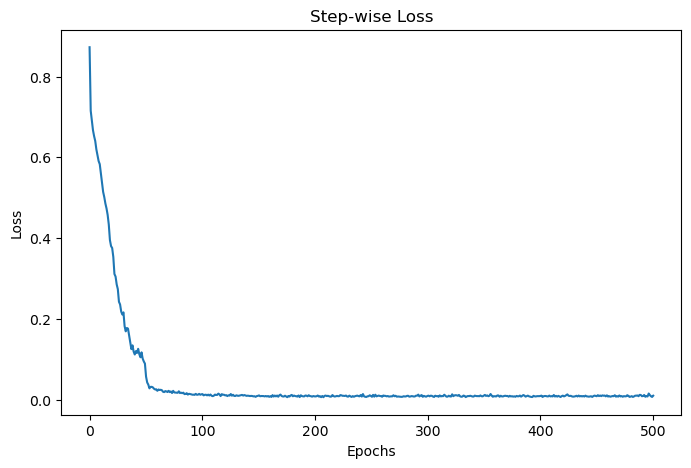

In [11]:
step = np.linspace(0, int(num_epochs), int(num_epochs))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.yscale('log')
plt.show()

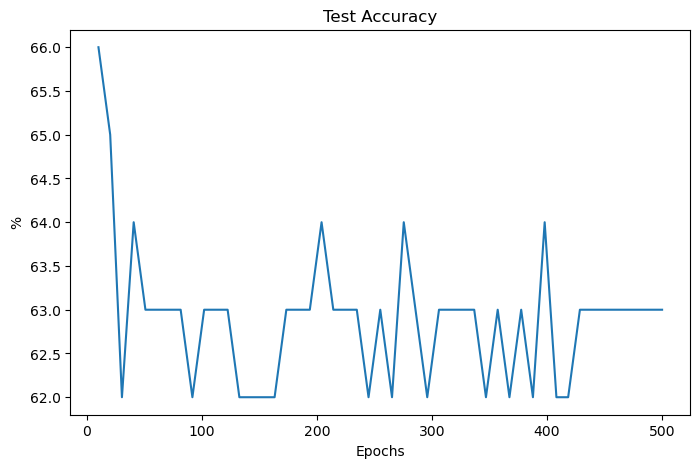

In [16]:
step = np.linspace(10, 500, 49)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(test_acc))
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("%")
#plt.yscale('log')
plt.show()

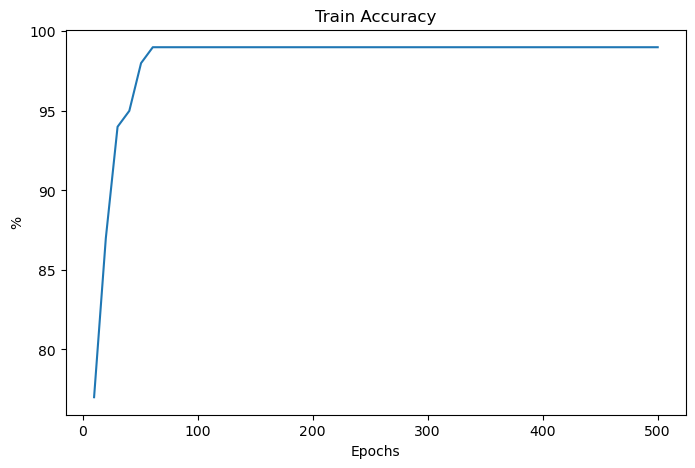

In [17]:
step = np.linspace(10, 500, 49)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(train_acc))
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("%")
#plt.yscale('log')
plt.show()

In [18]:
y_pred, y_test,correct,total = [],[],0,0
with torch.no_grad():
    for X, y in train_dataloader:
        outputs = model(X)
        _, predicted = torch.max(outputs.data, dim=1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
print(f'Accuracy of the network on the 7500 train instances: {100 * correct // total}%')

Accuracy of the network on the 7500 train instances: 99%


In [19]:
y_pred, y_test,correct,total = [],[],0,0
with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        _, predicted = torch.max(outputs.data, dim=1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        y_test = np.array(list(y_test)+list(np.array(y)))
        y_pred = np.array(list(y_pred)+list(np.array(predicted)))
print(f'Accuracy of the network on the 2500 test instances: {100 * correct // total}%')

Accuracy of the network on the 2500 test instances: 63%


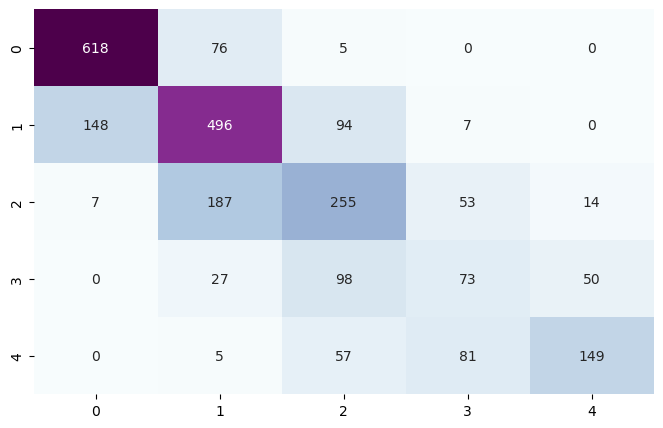

In [20]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g",cmap = 'BuPu')

plt.show()